In [7]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
# Chargement des données
data_path = './Cleaned_Human_Vital_Signs.csv'
health_data = pd.read_csv(data_path)



# Vérification des noms de colonnes et suppression des colonnes inutiles
print("Colonnes initiales:", health_data.columns)





Colonnes initiales: Index(['HR (BPM)', 'SpO2 (%)', 'TEMP (*C)', 'OUTPUT'], dtype='object')


In [8]:
health_data

,HR (BPM),SpO2 (%),TEMP (*C),OUTPUT
0,94.0,97.0,36.2,Normal
1,94.0,97.0,36.2,Normal
2,101.0,93.0,38.0,Abnormal
3,55.0,100.0,35.0,Abnormal
4,93.0,95.0,37.0,Normal
...,...,...,...,...
6676,91.0,100.0,36.0,Abnormal
6677,94.0,98.0,36.4,Normal
6678,94.0,97.0,36.2,Normal
6679,93.0,95.0,37.0,Normal


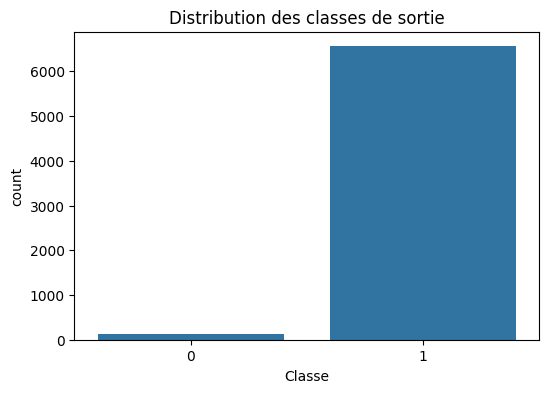

In [9]:
plt.figure(figsize=(6, 4))  # Ajustez la taille si nécessaire
sns.countplot(x='OUTPUT', data=health_data)
plt.title("Distribution des classes de sortie")
plt.xlabel('Classe')
plt.ylabel('count')
plt.xticks([0, 1], ['0', '1'])  # Ajustez les étiquettes selon vos données
plt.show()

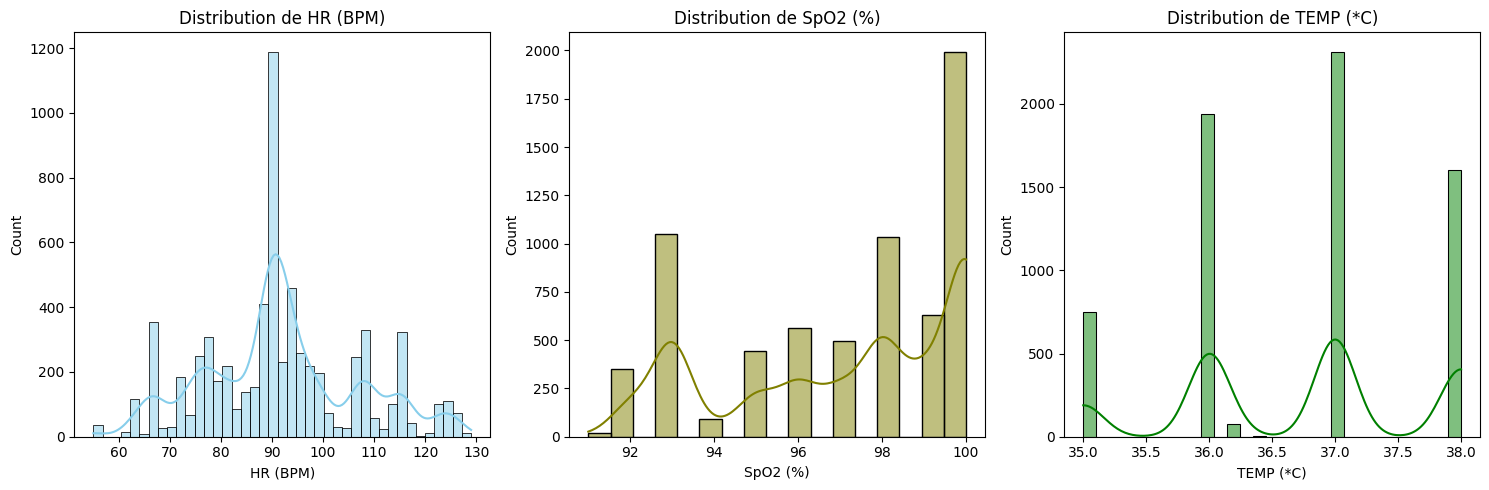

In [11]:
# Visualisation des distributions initiales de HR, SpO2, et TEMP
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(health_data['HR (BPM)'], kde=True, color="skyblue")
plt.title('Distribution de HR (BPM)')

plt.subplot(1, 3, 2)
sns.histplot(health_data['SpO2 (%)'], kde=True, color="olive")
plt.title('Distribution de SpO2 (%)')

plt.subplot(1, 3, 3)
sns.histplot(health_data['TEMP (*C)'], kde=True, color="green")
plt.title('Distribution de TEMP (*C)')
plt.tight_layout()
plt.show()


In [12]:
# Gestion des valeurs manquantes
print("Forme initiale des données:", health_data.shape)
health_data.dropna(inplace=True)
print("Forme des données après suppression des NA:", health_data.shape)




Forme initiale des données: (6681, 4)
Forme des données après suppression des NA: (6681, 4)


C:\Users\asus\AppData\Local\Temp\ipykernel_8924\4205240237.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  health_data['OUTPUT'] = health_data['OUTPUT'].str.strip().str.lower().replace({'normal': 0, 'abnormal': 1})


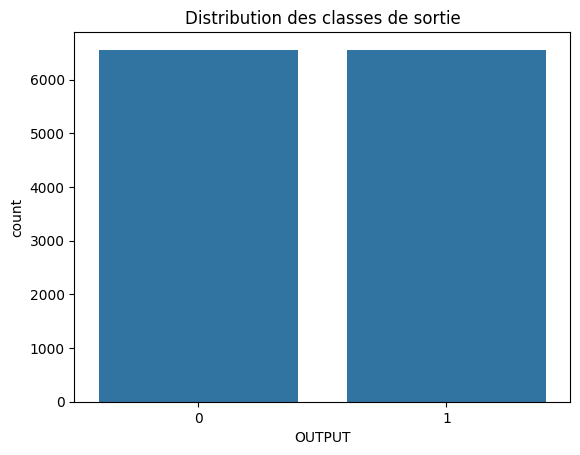

In [13]:
# Normalisation des valeurs de la colonne 'OUTPUT'
health_data['OUTPUT'] = health_data['OUTPUT'].str.strip().str.lower().replace({'normal': 0, 'abnormal': 1})

# Équilibrage des classes par suréchantillonnage
df_major = health_data[health_data['OUTPUT'] == 1]
df_minor = health_data[health_data['OUTPUT'] == 0]
df_minor_oversampled = df_minor.sample(n=len(df_major), replace=True, random_state=42)
df_balanced = pd.concat([df_major, df_minor_oversampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Affichage de la distribution des classes
plt.figure()
sns.countplot(x='OUTPUT', data=df_balanced)
plt.title("Distribution des classes de sortie")
plt.show()



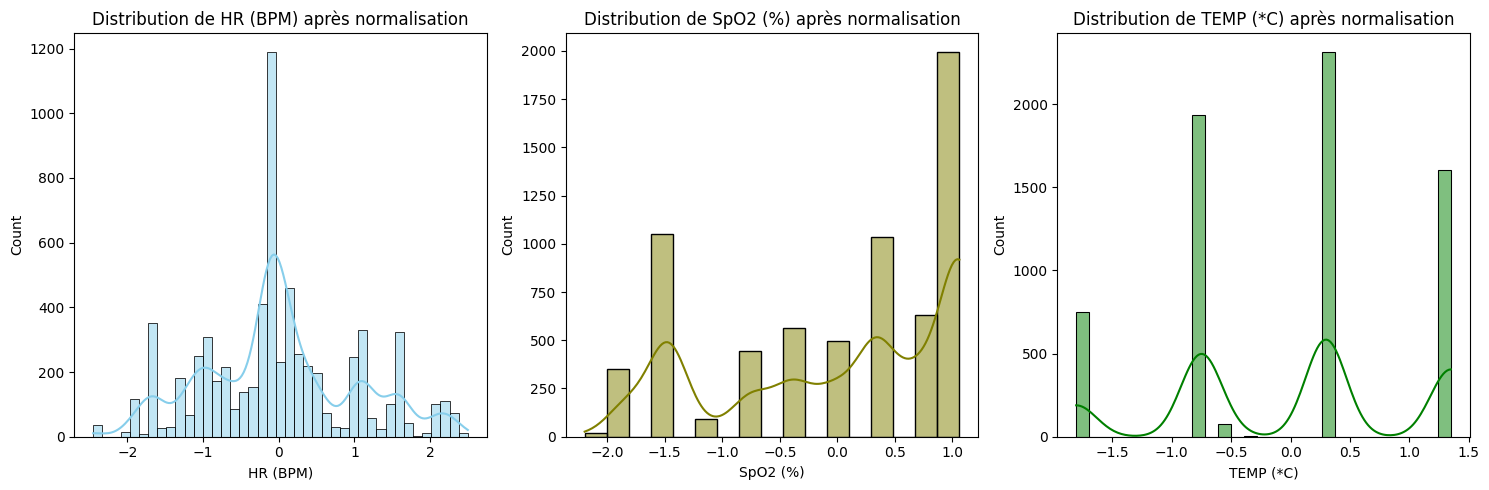

In [15]:
# Normalisation des données pour la visualisation
scaler_vis = StandardScaler()
health_data_scaled = scaler_vis.fit_transform(health_data[['HR (BPM)', 'SpO2 (%)', 'TEMP (*C)']])
health_data_scaled_df = pd.DataFrame(health_data_scaled, columns=['HR (BPM)', 'SpO2 (%)', 'TEMP (*C)'])

# Visualisation des distributions après normalisation
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(health_data_scaled_df['HR (BPM)'], kde=True, color="skyblue")
plt.title('Distribution de HR (BPM) après normalisation')

plt.subplot(1, 3, 2)
sns.histplot(health_data_scaled_df['SpO2 (%)'], kde=True, color="olive")
plt.title('Distribution de SpO2 (%) après normalisation')

plt.subplot(1, 3, 3)
sns.histplot(health_data_scaled_df['TEMP (*C)'], kde=True, color="green")
plt.title('Distribution de TEMP (*C) après normalisation')
plt.tight_layout()
plt.show()


In [16]:
# Préparation des données pour l'entraînement
X = df_balanced.iloc[:,:-1]
Y = df_balanced['OUTPUT']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("Taille de l'ensemble d'entraînement :", x_train.shape[0])
print("Taille de l'ensemble de test :", x_test.shape[0])


Taille de l'ensemble d'entraînement : 10494
Taille de l'ensemble de test : 2624


In [18]:

# Fonction d'évaluation du modèle
def evaluate_model(model, x_train, y_train, x_test, y_test, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Génération du rapport de classification
    report = classification_report(y_test, y_pred, output_dict=True)  # Sauvegarde du rapport sous forme de dictionnaire
    print(f"Évaluation du modèle: {model_name}")
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred))  # Affichage du rapport en format texte
    
    # Affichage de la matrice de confusion
    print("Matrice de confusion :")
    plt.title(f'Matrice de Confusion - {model_name}')
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.show()
    
    # Affichage des métriques globales
    print("Métriques globales :")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision (moyenne pondérée): {report['weighted avg']['precision']:.2f}")
    print(f"Recall (moyenne pondérée): {report['weighted avg']['recall']:.2f}")
    print(f"F1-Score (moyenne pondérée): {report['weighted avg']['f1-score']:.2f}")
    
    # Utilisation de la validation croisée pour évaluer la généralisation du modèle
    scores_cv = cross_val_score(model, X_scaled, Y, cv=5)
    print("Scores de validation croisée :", scores_cv)
    print("Précision moyenne de CV :", np.mean(scores_cv))
    
    # Tracé de la courbe ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (aire = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title(f'Courbe ROC - {model_name}')
    plt.legend(loc='lower right')
    plt.show()


Évaluation du modèle: Naive Bayes
Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      1260
           1       0.95      0.88      0.91      1364

    accuracy                           0.91      2624
   macro avg       0.92      0.92      0.91      2624
weighted avg       0.92      0.91      0.91      2624

Matrice de confusion :


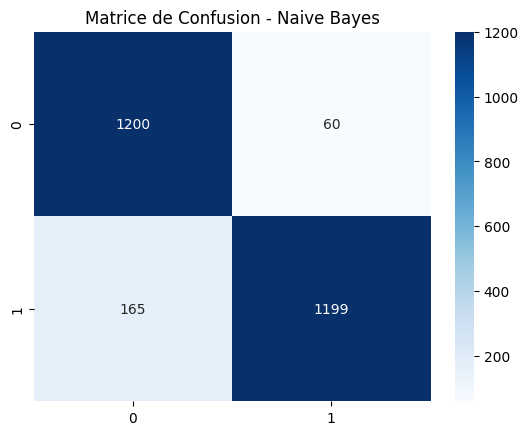

Métriques globales :
Accuracy: 0.91
Precision (moyenne pondérée): 0.92
Recall (moyenne pondérée): 0.91
F1-Score (moyenne pondérée): 0.91
Scores de validation croisée : [0.91501524 0.90891768 0.9211128  0.91383912 0.91345787]
Précision moyenne de CV : 0.9144685439777577


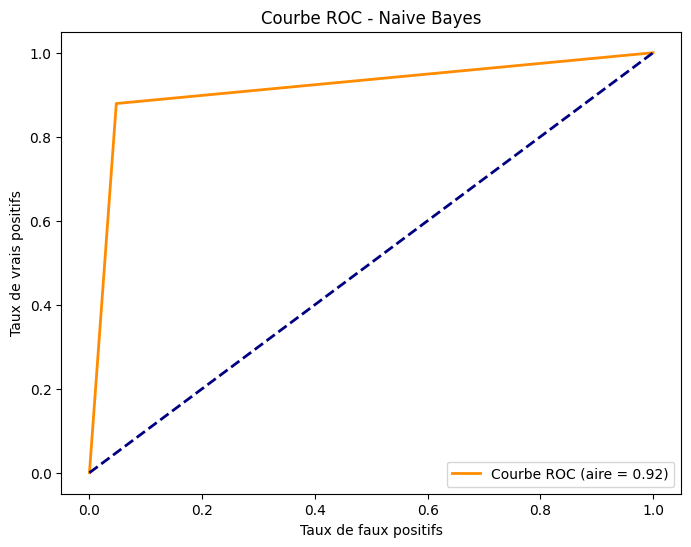

In [19]:
# # Évaluation du modèle Naive Bayes
nb_model = GaussianNB()
evaluate_model(nb_model, x_train, y_train, x_test, y_test, "Naive Bayes")

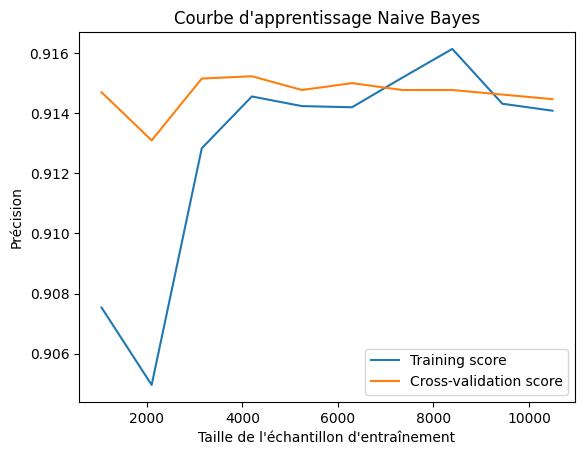

In [20]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    nb_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
plt.title('Courbe d\'apprentissage Naive Bayes')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('Précision')
plt.legend()


Évaluation du modèle: SVM
Rapport de classification :
              precision    recall  f1-score   support

           0       0.58      0.67      0.62      1260
           1       0.64      0.55      0.59      1364

    accuracy                           0.60      2624
   macro avg       0.61      0.61      0.60      2624
weighted avg       0.61      0.60      0.60      2624

Matrice de confusion :


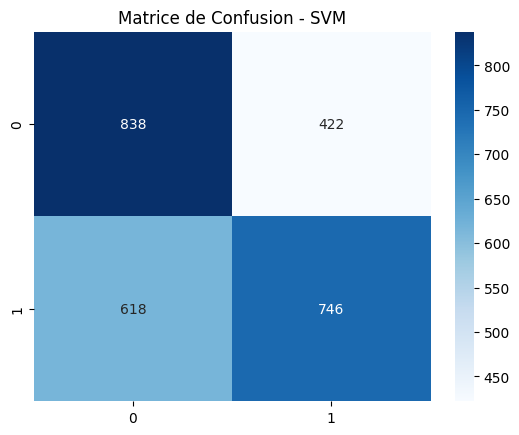

Métriques globales :
Accuracy: 0.60
Precision (moyenne pondérée): 0.61
Recall (moyenne pondérée): 0.60
F1-Score (moyenne pondérée): 0.60
Scores de validation croisée : [0.74123476 0.73132622 0.74466463 0.74189859 0.73922989]
Précision moyenne de CV : 0.7396708177194239


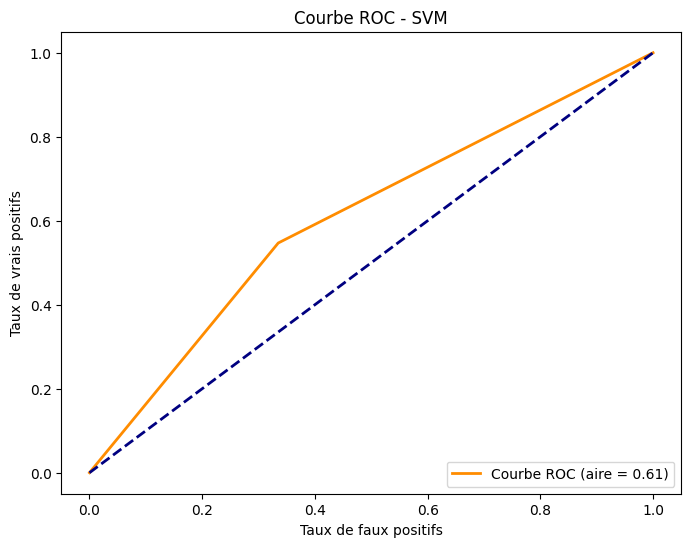

In [21]:
# # Exemple d'utilisation avec le modèle SVM
svm_model = SVC(kernel='linear', random_state=42)
evaluate_model(svm_model, x_train, y_train, x_test, y_test, "SVM")

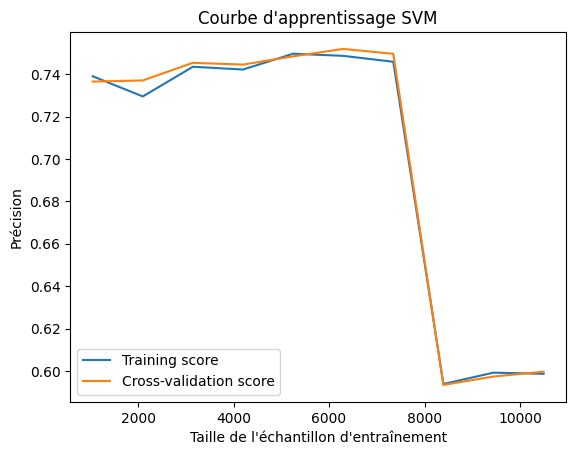

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    svm_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
plt.title('Courbe d\'apprentissage SVM')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('Précision')
plt.legend()


Évaluation du modèle: Logistic Regression
Rapport de classification :
              precision    recall  f1-score   support

           0       0.70      0.98      0.82      1260
           1       0.97      0.61      0.75      1364

    accuracy                           0.79      2624
   macro avg       0.84      0.80      0.79      2624
weighted avg       0.84      0.79      0.78      2624

Matrice de confusion :


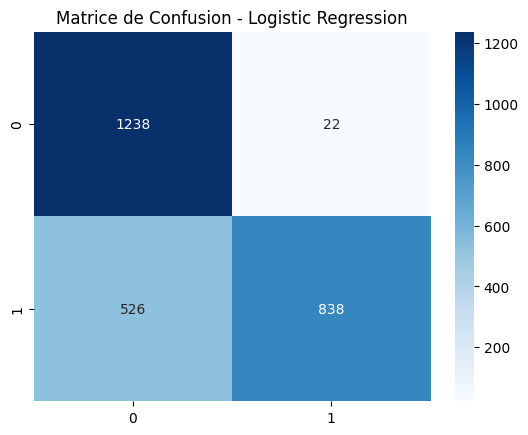

Métriques globales :
Accuracy: 0.79
Precision (moyenne pondérée): 0.84
Recall (moyenne pondérée): 0.79
F1-Score (moyenne pondérée): 0.78
Scores de validation croisée : [0.79496951 0.79115854 0.80106707 0.79832253 0.7998475 ]
Précision moyenne de CV : 0.7970730312526151


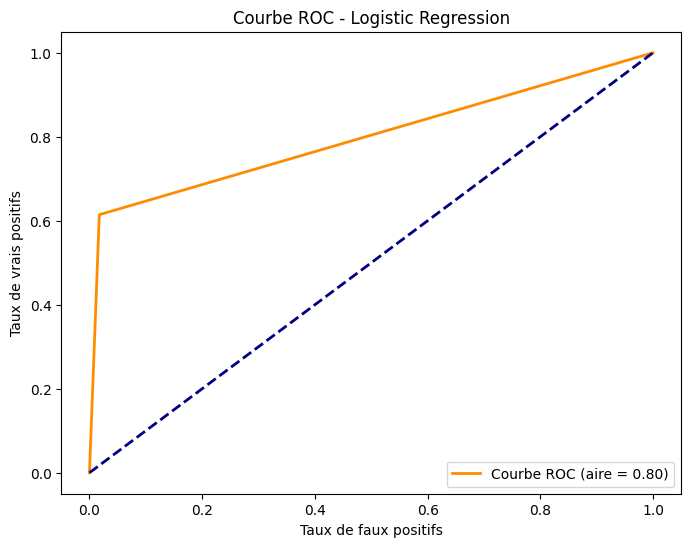

In [25]:
# Évaluation du modèle Logistic Regression
lr_model = LogisticRegression(random_state=42)
evaluate_model(lr_model, x_train, y_train, x_test, y_test, "Logistic Regression")

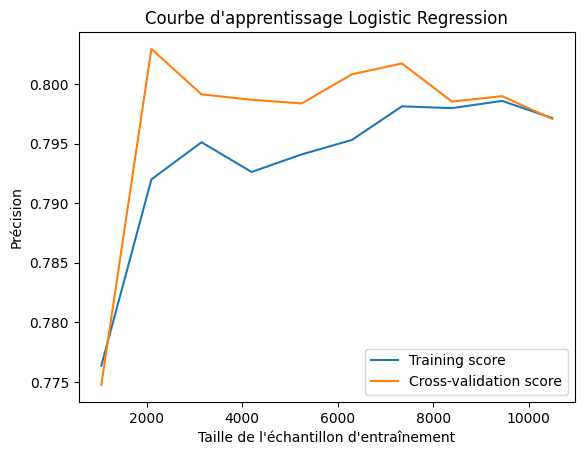

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    lr_model, X, Y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

# Calcul de la moyenne et de l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

# Tracé des courbes d'apprentissage
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
plt.title('Courbe d\'apprentissage Logistic Regression')
plt.xlabel('Taille de l\'échantillon d\'entraînement')
plt.ylabel('Précision')
plt.legend()


In [27]:
import pickle

# Supposons que `lr_model` est votre modèle de régression logistique entraîné
# Exportation du modèle au format .pkl
with open('final_model.pkl', 'wb') as file:
    pickle.dump(nb_model, file)


In [28]:
import pickle

# Chargement du modèle
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Utilisation du modèle chargé
# Exemple: prediction = loaded_model.predict(data)


In [29]:
import pickle

# Chargement du modèle
with open('final_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Utilisation du modèle chargé
# Exemple: prediction = loaded_model.predict(data)


In [39]:
# Exemple de données de test basé sur le modèle formé
test_data = [[98,97,36.5]]  # 72 BPM, 98% SpO2, 36.5°C


In [40]:
# Faire des prédictions avec le modèle chargé
predictions = loaded_model.predict(test_data)
print("Prédictions :", predictions)


Prédictions : [0]


c:\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
